###Mount Drive and Import Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import SelectFromModel, mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
import math

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings

import pickle

# Input data files are available in the "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/data_description.txt
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/train.csv
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/sample_submission.csv
/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/test.csv


###Import and Clean Data

####Data Mapping

In [3]:
QualMap = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'None': 0,
}

# Features already accounted for
# - 1/1.5/2/2.5 Stories
# - Duplex
# - 2 Family Conversion
# - Split Foyer
# - Split Level
# Features that can be extracted
# - Is a PUD
# - Has a finished attic (only first story)
# - Newer/Older (covered by year built?)
MSSubClassMap = {
  20: "1S_1946+",
  30: "1S_1945-",
  40: "1S_WA",
  45: "1.5S_U",
  50: "1.5S_F",
  60: "2S_1946+",
  70: "2S_1945-",
  75: "2.5S",
  80: "Split_Multi",
  85: "Split_Foyer",
  90: "Duplex",
  120: "1S_PUD_1946+",
  150: "1.5S_PUD",
  160: "2S_PUD_1946+",
  180: "PUD_Multi",
  190: "2_Fam_Conv"
}

MSPUDMap = {
  20: 0,
  30: 0,
  40: 0,
  45: 0,
  50: 0,
  60: 0,
  70: 0,
  75: 0,
  80: 0,
  85: 0,
  90: 0,
  120: 1,
  150: 1,
  160: 1,
  180: 1,
  190: 0
}

StreetMap = {
    'Grvl': 0,
    'Pave': 1,
}

AlleyMap = {
    'None': 1,
    'Grvl': 2,
    'Pave': 3
}

LotShapeMap = {
    'Reg': 1,	
    'IR1': 2,
    'IR2': 3,
    'IR3': 4
}

UtilitiesMap = {
    'AllPub': 4,
    'NoSewr': 3,
    'NoSeWa': 2,
    'ELO': 1
}

LandSlopeMap = {
    'Gtl': 1,
    'Mod': 2,
    'Sev': 3
}

BsmtExposureMap = {
    'Gd': 4,
    'Av': 3,
    'Mn': 2,
    'No': 1,
    'None': 0,
}

CentralAirMap = {
    'N': 0,
    'Y': 1
}

GarageFinishMap = {
    'Fin': 3,
    'RFn': 2,
    'Unf': 1,
    'None': 0
}

PavedDriveMap = {
    'Y':2,
    'P':1,
    'N':0
}

####Data Cleaning

In [4]:
# Merge dummies
def dummy_and_merge(df, new_col, old_cols):
  dummies = None
  for old_col in old_cols:
    if dummies is None:
      dummies = pd.get_dummies(df[old_col], prefix=new_col)
    else:                      
      dummies = dummies.add(pd.get_dummies(df[old_col], prefix=new_col), fill_value=0).astype(int).clip(0, 1)
  return dummies

def cleanDataframe(df):
  print('\nBefore:\n',df.isna().sum().sort_values().tail(34))

  #### Filling Nulls
  ## fill null catagoricals and ordinals
  # ordinals
  df['Alley'].fillna(value = 'None',inplace = True)
  #df['BsmtQual'].fillna(value = 'None',inplace = True)
  #df['BsmtExposure'].fillna(value = 'None',inplace = True)
  #df['BsmtCond'].fillna(value = 'None',inplace = True)
  #df['GarageQual'].fillna(value = 'None',inplace = True)
  #df['GarageCond'].fillna(value = 'None',inplace = True)
  df['FireplaceQu'].fillna(value = 'None',inplace = True)
  df['PoolQC'].fillna(value = 'None',inplace = True)
  # catagoricals
  #df['GarageType'].fillna(value = 'None',inplace = True)
  df.loc[df['BsmtQual'].isna().index, 'HasBasement'] = 0
  df.loc[df['BsmtQual'].notna().index, 'HasBasement'] = 1
  df.loc[df['GarageType'].isna().index, 'HasGarage'] = 0
  df.loc[df['GarageType'].notna().index, 'HasGarage'] = 1
  df['Fence'].fillna(value = 'None',inplace = True)
  df['MiscFeature'].fillna(value = 'None',inplace = True)
  
  index = df[df['MasVnrType'].isna() & df['MasVnrArea'].isna()].index
  df.loc[index,'MasVnrArea'] = 0
  index = df[df['MasVnrType'].isna() & (df['MasVnrArea'] == 0)].index
  df.loc[index,'MasVnrType'] = 'None'

  # drop null rows
  df = df.loc[df['Electrical'].notna(),:]
  #df = df[df['MasVnrType'].notna()]
  #index1 = df[(df['BsmtExposure'].isna()) & (df['BsmtCond'].notna())].index
  #index2 = df[(df['BsmtFinType2'].isna()) & (df['BsmtCond'].notna())].index
  #df.drop(index = index1,axis=0,inplace=True)
  #df.drop(index = index2,axis=0,inplace=True)

  # drop null columns
  df.drop(['GarageYrBlt'], axis=1, inplace=True)
  
  #### Ordinal Encoding
  # apply data maps
  '''
  df.loc[:,"ExterQual"] = df["ExterQual"].map(QualMap, 'ignore')
  df.loc[:,"ExterCond"] = df["ExterCond"].map(QualMap, 'ignore')
  df.loc[:,"BsmtQual"] = df["BsmtQual"].map(QualMap, 'ignore')
  df.loc[:,"BsmtCond"] = df["BsmtCond"].map(QualMap, 'ignore')
  df.loc[:,"HeatingQC"] = df["HeatingQC"].map(QualMap, 'ignore')
  df.loc[:,"KitchenQual"] = df["KitchenQual"].map(QualMap, 'ignore')
  df.loc[:,"FireplaceQu"] = df["FireplaceQu"].map(QualMap)
  df.loc[:,"GarageQual"] = df["GarageQual"].map(QualMap, 'ignore')
  df.loc[:,"GarageCond"] = df["GarageCond"].map(QualMap, 'ignore')
  df.loc[:,"PoolQC"] = df["PoolQC"].map(QualMap)
  df.loc[:,"Alley"] = df["Alley"].map(AlleyMap)
  df.loc[:,"LotShape"] = df["LotShape"].map(LotShapeMap, 'ignore')
  df.loc[:,"Utilities"] = df["Utilities"].map(UtilitiesMap, 'ignore')
  df.loc[:,"LandSlope"] = df["LandSlope"].map(LandSlopeMap, 'ignore')
  df.loc[:,"BsmtExposure"] = df["BsmtExposure"].map(BsmtExposureMap, 'ignore')
  df.loc[:,"GarageFinish"] = df["GarageFinish"].map(GarageFinishMap, 'ignore')
  df.loc[:,"PavedDrive"] = df["PavedDrive"].map(PavedDriveMap, 'ignore')
  '''

  #### One-Hot Encoding
  # apply data maps
  df.loc[:,"MSPUD"] = df["MSSubClass"].map(MSPUDMap)
  #df["MSSubClass"] = df["MSSubClass"].map(MSSubClassMap)
  df.drop(['MSSubClass'], axis=1, inplace=True)
  #df.loc[:,"Street"] = df["Street"].map(StreetMap)
  df.loc[:,"CentralAir"] = df["CentralAir"].map(CentralAirMap)
  
  # merge similar catagories
  condition_dummies = dummy_and_merge(df, 'Condition', ['Condition1', 'Condition2'])
  df.drop(labels=['Condition1', 'Condition2'], axis=1, inplace=True)
  exterior_dummies = dummy_and_merge(df, 'Exterior', ['Exterior1st', 'Exterior2nd'])
  df.drop(labels=['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

  print('\nAfter:\n', df.isna().sum().sort_values().tail(24))

  # Make dummy values
  df = pd.get_dummies(df)

  # Fill MiscFeature Dummies with MiscVal amounts
  df.loc[:,'MiscFeature_Gar2'] *= df['MiscVal']
  df.loc[:,'MiscFeature_Shed'] *= df['MiscVal']
  df.loc[:,'MiscFeature_Othr'] *= df['MiscVal']
  df.loc[:,'MiscFeature_None'] *= df['MiscVal']
  df.drop(['MiscVal'], axis=1, inplace=True)

  # Join merged dummies
  df = df.join(condition_dummies)
  df = df.join(exterior_dummies)
  return df

In [5]:
dftrain = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/train.csv').sample(frac = 1)
dftest = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/input/test.csv').sample(frac = 1)
# clean the data
dftrain = cleanDataframe(dftrain)
dftest = cleanDataframe(dftest)

# Seperate sales price column
df_SalePrice = dftrain['SalePrice']

# drop features not shared between data
dftrain.drop(list(set(dftrain.columns.values.tolist()).symmetric_difference(set(dftest.columns.values.tolist())) & set(dftrain.columns.values.tolist())), axis=1, inplace=True)
dftest.drop(list(set(dftrain.columns.values.tolist()).symmetric_difference(set(dftest.columns.values.tolist())) & set(dftest.columns.values.tolist())), axis=1, inplace=True)

# save some sample data to csv for demonstration
dftrain.join(df_SalePrice).sample(10).to_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/output/demo.csv')

# Separate Id column
dftest_Ids = dftest['Id']
dftrain.drop(["Id"], axis=1, inplace=True)
dftest.drop(["Id"], axis=1, inplace=True)

# Display
pd.set_option('display.max_columns', None)
dftrain.describe()
print(len(dftrain.columns.values.tolist()))
print(dftrain.columns.values.tolist())
print(len(dftest.columns.values.tolist()))
print(dftest.columns.values.tolist())

print('\nTrain Nulls:\n', dftrain.isna().sum().sort_values().tail(24))
print('\nTest Nulls:\n', dftest.isna().sum().sort_values().tail(24))
'''
print(len(list(set(dftrain.columns.values.tolist()).symmetric_difference(set(dftest.columns.values.tolist())))))
print(list(set(dftrain.columns.values.tolist()).symmetric_difference(set(dftest.columns.values.tolist()))))
print(len(list(set(dftrain.columns.values.tolist()).symmetric_difference(set(dftest.columns.values.tolist())) & set(dftrain.columns.values.tolist()))))
print(list(set(dftrain.columns.values.tolist()).symmetric_difference(set(dftest.columns.values.tolist())) & set(dftrain.columns.values.tolist())))
print(len(list(set(dftrain.columns.values.tolist()).symmetric_difference(set(dftest.columns.values.tolist())) & set(dftest.columns.values.tolist()))))
print(list(set(dftrain.columns.values.tolist()).symmetric_difference(set(dftest.columns.values.tolist())) & set(dftest.columns.values.tolist())))
'''
''''''


Before:
 HouseStyle         0
OverallQual        0
OverallCond        0
LotConfig          0
YearBuilt          0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
ExterQual          0
ExterCond          0
Foundation         0
MSSubClass         0
YearRemodAdd       0
Utilities          0
Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtFinType2      38
BsmtExposure      38
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
GarageCond        81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

After:
 LotConfig         0
RoofStyle         0
MSPUD             0
Heating           0
TotalBsmtSF       0
MasVnrType        0
MasVnrArea        0
ExterQual         0
ExterCond         0
Foundation        0
RoofMatl          0
BsmtFinSF1        0
BsmtFinSF2    

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl


Before:
 HouseStyle         0
GarageCars         1
GarageArea         1
KitchenQual        1
Exterior1st        1
SaleType           1
TotalBsmtSF        1
BsmtUnfSF          1
Exterior2nd        1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFullBath       2
Functional         2
Utilities          2
BsmtHalfBath       2
MSZoning           4
MasVnrArea        15
MasVnrType        16
BsmtFinType2      42
BsmtFinType1      42
BsmtExposure      44
BsmtQual          44
BsmtCond          45
GarageType        76
GarageFinish      78
GarageYrBlt       78
GarageQual        78
GarageCond        78
LotFrontage      227
FireplaceQu      730
Fence           1169
Alley           1352
MiscFeature     1408
PoolQC          1456
dtype: int64

After:
 SaleType          1
GarageArea        1
BsmtUnfSF         1
BsmtFinSF2        1
TotalBsmtSF       1
BsmtFinSF1        1
GarageCars        1
KitchenQual       1
MasVnrType        1
BsmtFullBath      2
Utilities         2
Functional        2
BsmtHalfBath  

''

In [6]:
catagorical_features = [
    "MSPUD",
    "Street",
    "CentralAir",
]

ordinal_features = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
    "Alley",
    "LotShape",
    "Utilities",
    "LandSlope",
    "BsmtExposure",
    "GarageFinish",
    "PavedDrive",
]

ordinal_features = []

numeric_features = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    #"GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    #"MiscVal",    # separate this value based on MiscFeature
    "MiscFeature_Gar2",
    "MiscFeature_None",
    "MiscFeature_Othr",
    "MiscFeature_Shed",
    #"MiscFeature_Elev",
    #"MiscFeature_TenC",
    "MoSold",
    "YrSold",
]

###Configure Models

Scoring functions

In [7]:
def root_mean_squared_log_error(y_true, y_pred):
  try:
    y_true[y_true<0] = 1
    y_pred[y_pred<0] = 1
    return mean_squared_error(np.log(y_true), np.log(y_pred), squared=False)
  except:
    return 1

def rms_log_loss(estimator, X, y):
  return -root_mean_squared_log_error(estimator.predict(X), y)

Models

In [8]:
class CustomPipeline:
  def __init__(self, imputer, scaler, encoder, estimator, isKerasModel=False, epochs=1, **args):
    self.pipeline = build_pipeline(imputer, scaler, encoder, estimator)
    self.imputer = imputer
    self.scaler = scaler
    self.encoder = encoder
    self.estimator = estimator
    self.isKerasModel = isKerasModel
    self.epochs = epochs
  
  def fit(self, X, y):
    if (self.isKerasModel):
      self.pipeline[2].reset_states() 
      return self.pipeline.fit(X, y, regressor__epochs=self.epochs, regressor__verbose=0)
    else:
      return self.pipeline.fit(X, y)
  
  def predict(self, X):
    return self.pipeline.predict(X)

  def get_params(self, deep=False):
    if deep:
      return self.pipeline.get_params(deep).update({"imputer":self.imputer, "scaler":self.scaler, "encoder":self.encoder, "estimator":self.estimator, "isKerasModel":self.isKerasModel, "epochs":self.epochs})
    else:
      return {"imputer":self.imputer, "scaler":self.scaler, "encoder":self.encoder, "estimator":self.estimator, "isKerasModel":self.isKerasModel, "epochs":self.epochs}

def build_pipeline(imputer, scaler, encoder, estimator):
  numeric_transformer = Pipeline(steps=[
      ('imputer', imputer),
      ('scaler', scaler),
  ])

  preprocessor = ColumnTransformer(
      transformers=[('numeric', numeric_transformer, numeric_features + ordinal_features)],
      remainder = "passthrough"
  )

  pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('encoder', encoder),
    ('regressor', estimator)
  ])

  return pipeline

In [9]:
# Catagorical Imputers for filling remaining nulls
catagorical_imputers = [
    SimpleImputer(strategy='most_frequent')
]

# Numerical Imputers for filling remaining nulls
numeric_imputers = [
    SimpleImputer(strategy='median')
]

# Numerical Scalers
scalers = [
    #"passthrough",
    StandardScaler(),
    #QuantileTransformer(),
    #MinMaxScaler(),
    #RobustScaler(),
]

#encoder_output_size = [100, 150, 200]
encoder_output_size = [259]

def makeEncoders():
    encoders = []
    for size in encoder_output_size:
      encoders.append(SelectKBest(mutual_info_regression, k=size))
      encoders.append(PCA(size))
    return encoders

# Encoders
encoders = [
    #"passthrough",
] + makeEncoders()

#Sequetial FF Neural Net
def makeFNN(layerSize, layerNumber, learning_rate=0.3, dropout=0.2, output_activation='linear', hidden_activation='relu'):
  hiddenLayers = []
  for i in range(layerNumber):
    hiddenLayers.append((layerSize, hidden_activation))
  layersFNN = [layers.Input(shape=(encoder_output_size[0],))]
  for layer in hiddenLayers:
    layersFNN.append(layers.Dense(units=layer[0],activation=layer[1]))
    #layersFNN.append(layers.Dropout(dropout))
  layersFNN.append(layers.Dense(units=1,activation=output_activation))
  fnnModel = Sequential(layersFNN)
  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  fnnModel.compile(optimizer=optimizer, loss=tf.keras.losses.mean_squared_logarithmic_error)
  return fnnModel

# Models
estimators = [
    #(LinearRegression(), False),
    (LassoCV(max_iter=10000), False),
    (ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, .91, .95, .97, .99, .995, .999], max_iter=10000), False),
    (RidgeCV(scoring=None, store_cv_values=True, alphas=np.concatenate(([0.1], np.linspace(1, 100, num=99, endpoint=False)))), False),
    (MLPRegressor((64, 5), max_iter=1000, activation='relu', learning_rate_init=0.05, early_stopping=True, random_state=0), False),
    (makeFNN(64, 6, output_activation='relu'), True),
]

###Score Models (Cross Validation)

In [11]:
models = []
scores = []
# THIS WILL ERROR BECAUSE WE NEED SOMEWAY TO CHANGE THE INPUT LAYER OF THE FNN. PCA AND K BEST GIVE TWO DIFFERENT SIZE INPUTS 100 AND 150 WHICH THE FNN CANNOT HANDLE. NEEDS A SPECIFIC SIZE
for imputer in numeric_imputers:
  print(f'{imputer}')
  for scaler in scalers:
    print(f'{scaler}')
    for encoder in encoders:
      print(f'{encoder}\n')
      for estimator in estimators:
        pipeline = CustomPipeline(imputer, scaler, encoder, estimator[0], estimator[1], epochs=100)
        models.append(pipeline)
        val_scores = cross_validate(pipeline, dftrain, df_SalePrice, scoring=rms_log_loss, cv=10)
        scores.append(-1*np.array(val_scores["test_score"]))
        print()
        print(f'{str(estimator[0]).split("(")[0]}:\t{float(-1*np.mean(val_scores["test_score"]))}')
        print(f'Model fit time:\t{ np.sum(val_scores["fit_time"]) }')
        print(f'Model scores:\t{-1*np.array(val_scores["test_score"])}')
        print(f'Standard Dev:\t{np.std(-1*np.array(val_scores["test_score"]))}\n')

SimpleImputer(strategy='median')
StandardScaler()
passthrough


LassoCV:	0.1574521082614553
Model fit time:	15.380632638931274
Model scores:	[0.14871566 0.14590328 0.23568585 0.11725287 0.12636439 0.14301218
 0.21519185 0.13333468 0.16229707 0.14676325]
Standard Dev:	0.03629656873212663


ElasticNetCV:	0.14748616816667054
Model fit time:	38.03468203544617
Model scores:	[0.15121142 0.13571591 0.13039078 0.12344701 0.13037195 0.14675111
 0.21837054 0.12753544 0.16321001 0.14785751]
Standard Dev:	0.02643102326529031


RidgeCV:	0.15264516177526258
Model fit time:	4.508028030395508
Model scores:	[0.1513934  0.14448072 0.16549025 0.11866778 0.1285177  0.15098163
 0.2194403  0.13559112 0.16449994 0.14738877]
Standard Dev:	0.02625487004072433


MLPRegressor:	0.1783501958369055
Model fit time:	11.001498699188232
Model scores:	[0.15240124 0.15623662 0.13183104 0.18583635 0.17281992 0.1750219
 0.23732122 0.23943148 0.20124085 0.13136135]
Standard Dev:	0.03655753300594647

5/5 [===================

###Make Predictions

In [12]:
# Find the best model
bestScore = 1
bestScaler = None
#bestEncoder = None
bestModel = None
bestIdx = 0
for i in range(len(scores)):
  if (np.mean(scores[i]) < bestScore):
    bestScore = np.mean(scores[i])
    bestModel = models[i]
    bestIdx = i
print("Model Number", bestIdx+1, "\n", str(bestModel.pipeline[1]).split('(')[0], "\n", str(bestModel.pipeline[2]).split('(')[0], "\n", bestScore)

Model Number 2 
 passthrough 
 ElasticNetCV 
 0.14748616816667054


Text(0.5, 0, 'Sale Price ($)')

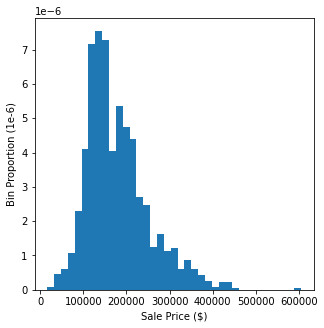

In [13]:
# Fit the best model
bestModel.fit(dftrain, df_SalePrice)
#bestModel.score(dftrain, df_SalePrice)

# Generate predictions for dftest and save them in a csv
test_pred = bestModel.predict(dftest).flatten()
np.savetxt('/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/output/prediction.csv', np.column_stack((dftest_Ids, test_pred)), fmt=['%u', '%.18f'], header='Id,SalePrice', delimiter=',', comments='')

# Save the model to a pickle file
with open("/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/output/model.pkl", "wb") as file:
  pickle.dump(bestModel, file)

def plot_hist(X, ax):
  IQR = np.quantile(X, 0.75) - np.quantile(X, 0.25)
  bin_width = 2 * IQR * pow(X.count(), -1/3)  # Use Freedman and Diaconis’ rule to find bin width
  bins = int((X.max() - X.min())/bin_width)
  X.plot.hist(bins=bins, density=1, ax=ax) 

f, axes = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(5,5))
plot_hist(pd.Series(test_pred), axes)
axes.set_ylabel('Bin Proportion (1e-6)')
axes.set_xlabel('Sale Price ($)')

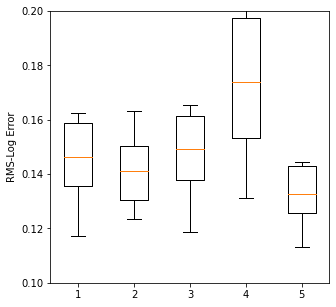

In [14]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(5,5))

ax.set_ylabel('RMS-Log Error')
ax.boxplot(scores)
plt.ylim([0.1, 0.2])
plt.show()

In [15]:
model = None
with open("/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/output/model.pkl", "rb") as file:
    model = pickle.load(file)

df_demo = pd.read_csv("/content/drive/MyDrive/house-prices-advanced-regression-techniques/Notebooks/output/demo.csv")
df_demo_ids = df_demo["Id"]
df_demo_prices = df_demo["SalePrice"]
df_demo.drop("Unnamed: 0", axis=1, inplace=True)
df_demo.drop("Id", axis=1, inplace=True)
df_demo.drop("SalePrice", axis=1, inplace=True)

demo_pred = model.predict(df_demo)

for i in range(len(df_demo_ids)):
  print(f'{df_demo_ids.get(i)}:\t{"{:0.2f}".format(float(demo_pred[i]))}\t{"{:0.2f}".format(float(df_demo_prices[i]))}')

#f, axes = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(5,5))
#plot_hist(pd.Series(test_pred), axes)
#axes.set_ylabel('Bin Proportion (1e-6)')
#axes.set_xlabel('Sale Price ($)')

1334:	123100.14	125500.00
941:	175662.39	150900.00
437:	125013.34	116000.00
696:	173305.84	176000.00
1080:	118917.28	126000.00
287:	177574.88	159000.00
509:	176266.37	161000.00
589:	235174.21	143000.00
340:	150559.94	155000.00
584:	291014.72	325000.00
